# Машинное обучение, ММП ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 09.12.2019

Мягкий дедлайн: 23:59MSK 22.12.2019

Жесткий дедлайн: 23:59MSK 29.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.96520334950183

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from tqdm import tqdm_notebook


def compute_biase_variance(regressor, X, y, num_runs=100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    
    predictions = np.zeros((X.shape[0], num_runs))
    predictions[:, :] = np.nan
    error = np.zeros((X.shape[0], num_runs))
    error[:, :] = np.nan
    indexes_all = np.arange(X.shape[0])
    
    for i  in tqdm_notebook(range(num_runs)):
        indexes_train = np.random.choice(indexes_all,
                                      size=X.shape[0],
                                      replace=True)
        indexes_test = np.setdiff1d(indexes_all, indexes_train)
        regressor.fit(X[indexes_train], y[indexes_train])
        
        predictions[indexes_test, i] = regressor.predict(X[indexes_test])
        error[indexes_test, i] = ((predictions[indexes_test, i] - y[indexes_test]) ** 2)

    mean_pred_obj = np.nanmean(predictions, axis=1)
    biase = np.mean((mean_pred_obj - y) ** 2)
    
    variance = np.mean(np.nanvar(predictions, axis=1))
    error = np.mean(np.nanmean(error, axis=1))
    
    return biase, variance, error

**Задание 2. (1 балл)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


lin_reg = LinearRegression()
dectree_reg = DecisionTreeRegressor()
randfor_reg = RandomForestRegressor()

In [9]:
ans_reg = compute_biase_variance(lin_reg, X, y)
ans_dec = compute_biase_variance(dectree_reg, X, y)
ans_for = compute_biase_variance(randfor_reg, X, y)

print(f'Смещение, разброс, ошибка для линейной регрессии: {ans_reg[0]:6.3f} {ans_reg[1]:6.3f} {ans_reg[2]:6.3f}')
print(f'Смещение, разброс, ошибка для решающего дерева:   {ans_dec[0]:6.3f} {ans_dec[1]:6.3f} {ans_dec[2]:6.3f}')
print(f'Смещение, разброс, ошибка для случайного леса:    {ans_for[0]:6.3f} {ans_for[1]:6.3f} {ans_for[2]:6.3f}')

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Смещение, разброс, ошибка для линейной регрессии: 23.756  0.876 24.632
Смещение, разброс, ошибка для решающего дерева:   10.226 13.730 23.956
Смещение, разброс, ошибка для случайного леса:    10.668  3.348 14.016


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ из полученных результатов видно, что:

1. Линейная регрессия обладает наибольшим смещением и наименьшим разбросом среди 3 выбранных алгоритмов (что является логичным, так как большое смещение и маленький разброс говорят о простоте модели).
1. Смещения решающего дерева и случайного леса практически не отличаются, так как из лекций известно, что бэггинг не изменяет смещение.
1. Видно, что разброс случайного леса сильно уменьшился относительно решающего дерева. Этот факт частично подтверждает теоретическую часть, рассказанную на лекциях: бэггинг уменьшает разброс в `m` раз, где `m` - количество выборок, сформированных с помощью бутстрапа. В данном случае `m = 10`, так как по умолчанию в `RandomForestRegressor` значение `n_estimators = 10`. Мне кажется, что рассхождение возможно из-за того, что в при построении деревьев в случайном лесе могут быть удалены некоторые признаки.

Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.


В теории бутстрап уменьшает разброс базового алгоритма в `m` раз, где `m` - количество выборок, сформированных с помощью бутстрапа.

Для того, чтобы это проверить запустим функцию `compute_biase_variance` с параметром `num_runs = 20` и `num_runs = 40` для каждого из трех алгоритмов. Ожидается, разброс каждого из алгоритмов при первом запуске будет больше в 2 раза, чем их разброс при втором запуске.

In [10]:
ans_reg = compute_biase_variance(lin_reg, X, y, num_runs=20)
ans_dec = compute_biase_variance(dectree_reg, X, y, num_runs=20)
ans_for = compute_biase_variance(randfor_reg, X, y, num_runs=20)

print(f'Смещение, разброс, ошибка для линейной регрессии при num_runs = 20: {ans_reg[0]:6.3f} {ans_reg[1]:6.3f} {ans_reg[2]:6.3f}')
print(f'Смещение, разброс, ошибка для решающего дерева при num_runs = 20:   {ans_dec[0]:6.3f} {ans_dec[1]:6.3f} {ans_dec[2]:6.3f}')
print(f'Смещение, разброс, ошибка для случайного леса при num_runs = 20:    {ans_for[0]:6.3f} {ans_for[1]:6.3f} {ans_for[2]:6.3f}')

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Смещение, разброс, ошибка для линейной регрессии при num_runs = 20: 23.786  0.779 24.564
Смещение, разброс, ошибка для решающего дерева при num_runs = 20:   13.293 11.192 24.485
Смещение, разброс, ошибка для случайного леса при num_runs = 20:    11.748  3.021 14.768


In [11]:
print(f'Смещение, разброс, ошибка для линейной регрессии при num_runs = 40: {compute_biase_variance(lin_reg, X, y, num_runs=40)}')
print(f'Смещение, разброс, ошибка для решающего дерева при num_runs = 40: {compute_biase_variance(dectree_reg, X, y, num_runs=40)}')
print(f'Смещение, разброс, ошибка для случайного леса при num_runs = 40: {compute_biase_variance(randfor_reg, X, y, num_runs=40)}')

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Смещение, разброс, ошибка для линейной регрессии при num_runs = 40: (23.685914063023777, 0.8128295758981108, 24.498743638921887)


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Смещение, разброс, ошибка для решающего дерева при num_runs = 40: (11.310788028990192, 12.219567511773604, 23.530355540763793)


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Смещение, разброс, ошибка для случайного леса при num_runs = 40: (11.43696864245284, 3.0239091838627954, 14.460877826315635)


__Your answer here:__ интересно, что в данных экспериментах не выполняются теоретические результаты.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
import random
random.seed(13)
np.random.seed(13)

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def plot_predictions(regressor, X, y, num_runs=1000, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=num_test_objects,
                                                        random_state=13)
    predictions = np.zeros((num_test_objects, num_runs))
    all_indexes = np.arange(X_train.shape[0])
    for i in range(num_runs):
        indexes_bs = np.random.choice(all_indexes,
                                      size=X_train.shape[0],
                                      replace=True)
        
        regressor.fit(X_train[indexes_bs], y_train[indexes_bs])
        predictions[:, i] = regressor.predict(X_test)
        if ax is None:
            plt.scatter(np.arange(X_test.shape[0]), predictions[:, i], color='black', label='y_preds')
        else:
            line_pred = ax.scatter(np.arange(X_test.shape[0]), predictions[:, i], color='black', label='y_preds')
    if ax is None:
        plt.scatter(np.arange(X_test.shape[0]), y_test, color='red', label='y_true')
    else:
        line_true = ax.scatter(np.arange(X_test.shape[0]), y_test, color='red', label='y_true')
        ax.title.set_text(title)
        ax.set_xlabel('Номер объекта из теста')
    return line_true, line_pred
    
    
    

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lin_reg = LinearRegression()
dectree_reg = DecisionTreeRegressor()
randforest_reg = RandomForestRegressor(20)

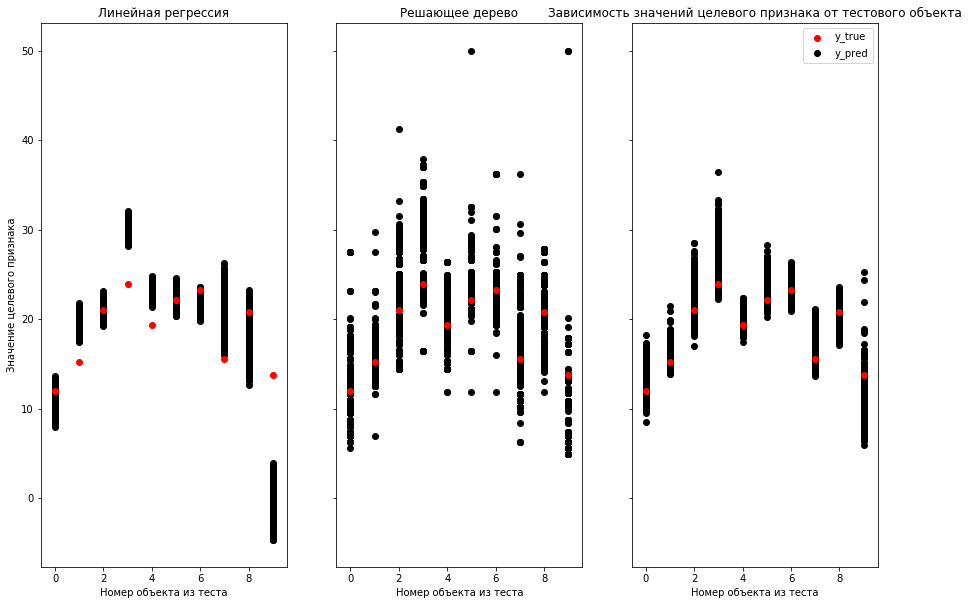

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
plot_predictions(lin_reg, X, y, ax=axs[0], title='Линейная регрессия')
plot_predictions(dectree_reg, X, y, ax=axs[1], title='Решающее дерево')
l_true, l_pred = plot_predictions(randforest_reg, X, y, ax=axs[2], title='Случайный лес')
axs[0].set_ylabel('Значение целевого признака')
plt.legend([l_true, l_pred],['y_true', 'y_pred'])
plt.title('Зависимость значений целевого признака от тестового объекта')
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**
по данным графикам видно, что выполняются выводы из задания номер 2:

1. Линейная регрессия обладает наибольшим смещением и наименьшим разбросом среди 3 выбранных алгоритмов (что является логичным, так как большое смещение и маленький разброс говорят о простоте модели).
1. Смещения решающего дерева и случайного леса практически не отличаются, так как из лекций известно, что бэггинг не изменяет смещение.
1. Видно, что разброс случайного леса сильно уменьшился относительно решающего дерева. Этот факт частично подтверждает теоретическую часть, рассказанную на лекциях: бэггинг уменьшает разброс в `m` раз, где `m` - количество выборок, сформированных с помощью бутстрапа. В данном случае `m = 10`, так как по умолчанию в `RandomForestRegressor` значение `n_estimators = 10`. Мне кажется, что рассхождение возможно из-за того, что в при построении деревьев в случайном лесе могут быть удалены некоторые признаки.




### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [16]:
train_data = pd.read_csv('./data/application_train.csv')

Y = train_data['TARGET']
train_data.drop(columns='TARGET', inplace=True)

 Какие признаки можно удалить?
 1. Удалим признак `SK_ID_CURR`, так уникальный идентификатор не несет никакой информации о целевом признаке
 1. Удалим признаки `WEEKDAY_APPR_PROCESS_START` и `HOUR_APPR_PROCESS_START`, так как они отвечают за день недели и время подачи заявки на кредит. 
 1. Удалим все признаки, в которых $количество\spaceпропусков >= 0.4 * (количество\spaceвсех\spaceзначений)$

In [17]:
#codeee

~~Будем считать, что признак категориальный, если количество уникальных значений 2 <= n <= 30~~

Будем считать, что признак категориальный, если его тип = 'object'.

In [18]:
#n_uniq = 30
#cat_features = []


#for col in train_data.columns:
#    uniq_amount = len(train_data[col].unique())
#    if (uniq_amount <= n_uniq) & (uniq_amount >= 2):
#        cat_features.append(col)     

In [19]:
%%time

cat_features = []


for col in train_data.columns:
    if train_data[col].dtype == 'object':
        cat_features.append(col)     

CPU times: user 4.61 ms, sys: 8 µs, total: 4.62 ms
Wall time: 4.62 ms


Для категориальных признаков заполнинм пропуски самым популярным значением, а для вещественных - средним по данному признаку.

In [20]:
for cat_col in cat_features:
    nan_mask = train_data[cat_col].isna()
    train_data.loc[nan_mask, cat_col] = train_data[cat_col].value_counts().index[0]

In [21]:
numerical_features = set(train_data.columns) - set(cat_features)


for numerical_col in numerical_features:
    mean_col = np.mean(train_data[numerical_col])
    train_data[numerical_col].fillna(mean_col, inplace=True)

Закодируем категориальные признаки с помощью one-hot-encoding:

In [22]:
def one_hot_encoding(data, cat_columns):
    data_ohe = data.copy()
    for cat_column in cat_columns:
        unique_values = data_ohe[cat_column].unique()
        for unique_value in unique_values:
            data_ohe[cat_column + '_' + str(unique_value)] = data_ohe[cat_column] == unique_value
            data_ohe[cat_column + '_' + str(unique_value)] =\
                data_ohe[cat_column + '_' + str(unique_value)].map({True: 1, False: 0})
    return data_ohe.drop(columns=cat_columns)

In [23]:
train_data_ohe = one_hot_encoding(train_data, cat_features)

Разобьем выборку в соотношении 70:30 с random_state=0.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, Y, test_size=0.3, random_state=0)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Почему получилась заметная разница в качестве?**

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [25]:
from sklearn.metrics import average_precision_score

In [26]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [27]:
%%time


lgbm_model = LGBMClassifier(n_jobs=-1)
lgbm_model.fit(X_train[numerical_features], y_train)
lgbm_preds = lgbm_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 31.4 s, sys: 1.01 s, total: 32.4 s
Wall time: 1.2 s


In [28]:
# CPU times: user 19 s, sys: 374 ms, total: 19.4 s
# Wall time: 1.38 s

In [29]:
%%time


catboost_model = CatBoostClassifier(verbose=0, thread_count=16)
catboost_model.fit(X_train[numerical_features], y_train)
catboost_preds = catboost_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 5min 54s, sys: 6.1 s, total: 6min
Wall time: 22.9 s


In [30]:
# CPU times: user 6min 56s, sys: 18.2 s, total: 7min 14s
# Wall time: 32.6 s

In [31]:
print(f'LGBM PR-AUC: {average_precision_score(y_test, lgbm_preds)}')
print(f'CatBoost PR-AUC: {average_precision_score(y_test, catboost_preds)}')

LGBM PR-AUC: 0.23839056491864832
CatBoost PR-AUC: 0.23894705678736883


**Your answer here:** Разница получилась совсем незначительной, хоть и Catboost обучался почти в 21 раз дольше.. LGBM показал качество лучше, так как, возможно, для этих данных "жадный алгоритм", встроенный в реализации LGBM, построения композиции дает лучший результат. Еще одна причина: мы совсем не использовали категориальные признаки, а они как раз являются ключевой особенностью библиотеки Catboost.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [39]:
%%time

import time

from tqdm import tqdm_notebook

max_depth_list = list(range(1, 15, 3))
tree_amount_list = [2000]#[1, 5, 10, 100, 300, 500, 700]
learning_rate_list = [1e-3]#[1e-3, 1e-2, 1e-1, 1]
loss_func_list = ['Logloss']

catboost_logger = {'max_depth_list': [],
                   'tree_amount_list': [],
                   'learning_rate_list': [],
                   'loss_func_list': [],
                   'AUC-PR_list': [],
                   'estimated_time': []
                  }

i = 0

for max_depth in tqdm_notebook(max_depth_list):
    for tree_amount in tree_amount_list:
        for lr in learning_rate_list:
            for loss_func in loss_func_list:
                start_time = time.time()
                catboost_model = CatBoostClassifier(max_depth=max_depth, n_estimators=tree_amount,
                                            learning_rate=lr, objective=loss_func,
                                             task_type='GPU', verbose=1000, thread_count=-1)
                
                catboost_model.fit(X_train[numerical_features], y_train)
                preds = catboost_model.predict_proba(X_test[numerical_features])[:, 1]
                catboost_logger['AUC-PR_list'].append(average_precision_score(y_test, preds))
                catboost_logger['max_depth_list'].append(max_depth)
                catboost_logger['tree_amount_list'].append(tree_amount)
                catboost_logger['learning_rate_list'].append(lr)
                catboost_logger['loss_func_list'].append(loss_func)
                catboost_logger['estimated_time'].append(time.time() - start_time)
                
                i += 1

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0:	learn: 0.6921329	total: 2.65ms	remaining: 5.29s
1000:	learn: 0.3098864	total: 1.82s	remaining: 1.81s
1999:	learn: 0.2718565	total: 3.59s	remaining: 0us
0:	learn: 0.6920788	total: 3.1ms	remaining: 6.2s
1000:	learn: 0.3019389	total: 2.59s	remaining: 2.59s
1999:	learn: 0.2635765	total: 5.23s	remaining: 0us
0:	learn: 0.6920323	total: 5.13ms	remaining: 10.3s
1000:	learn: 0.2981977	total: 4.76s	remaining: 4.75s
1999:	learn: 0.2601694	total: 9.67s	remaining: 0us
0:	learn: 0.6920223	total: 16.6ms	remaining: 33.2s
1000:	learn: 0.2948455	total: 15.7s	remaining: 15.7s
1999:	learn: 0.2555166	total: 32.1s	remaining: 0us
0:	learn: 0.6920082	total: 101ms	remaining: 3m 21s
1000:	learn: 0.2891839	total: 1m 33s	remaining: 1m 33s
1999:	learn: 0.2440586	total: 3m 16s	remaining: 0us

CPU times: user 4min 8s, sys: 2min 43s, total: 6min 51s
Wall time: 4min 10s


In [ ]:
import pickle

with open('catboost_logger.pkl', 'wb') as file:
    pickle.dump(catboost_logger, file)

In [ ]:
%%time

from tqdm import tqdm_notebook

max_depth_list = list(range(1, 15, 3))
tree_amount_list = [1, 5, 10, 100, 300, 500, 700]
learning_rate_list = [1e-3, 1e-2, 1e-1, 1]
loss_func_list = ['binary']

lgbm_logger = {'max_depth_list': [],
                   'tree_amount_list': [],
                   'learning_rate_list': [],
                   'loss_func_list': [],
                   'AUC-PR_list': [],
                   'estimated_time': []
                  }

i = 0

for max_depth in max_depth_list:
    for tree_amount in tree_amount_list:
        for lr in learning_rate_list:
            for loss_func in loss_func_list:
                lgbm_model = LGBMClassifier(max_depth=max_depth, n_estimators=tree_amount,
                                            learning_rate=lr, objective=loss_func,
                                             n_jobs=-1)
                
                lgbm_model.fit(X_train[numerical_features], y_train)
                preds = lgbm_model.predict_proba(X_test[numerical_features])[:, 1]
                lgbm_logger['AUC-PR_list'].append(average_precision_score(y_test, preds))
                lgbm_logger['max_depth_list'].append(max_depth)
                lgbm_logger['tree_amount_list'].append(tree_amount)
                lgbm_logger['learning_rate_list'].append(lr)
                lgbm_logger['loss_func_list'].append(loss_func)
                lgbm_logger['estimated_time'].append(time.time() - start_time)
                i += 1

In [ ]:
import pickle

with open('lgbm_logger.pkl', 'wb') as file:
    pickle.dump(, file)

**Your answer here:**